# Quantium Virtual Internship

### Task 2
### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import inspect, os, sys
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html td { white-space: pre; }</style>"))

sys.path.append('C://Users//Dhruv Sharma//AppData//Local//Programs//Python//Python37//Lib//site-packages')

### Getting the data

In [2]:
def store_df():
    script_path = inspect.getfile(inspect.currentframe())
    script_dir = os.path.dirname(os.path.abspath(script_path))
    data = pd.read_csv(os.path.join(script_dir, "QVI_data.csv"))
    with open('df.pickle', 'wb') as f:
        pickle.dump(data, f)

def get_df():
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)
        return df

if not os.path.exists('df.pickle'):
    store_df()
data = get_df()

### Creating the metrics

In [3]:
s = data['DATE'].str.split('-')
yearmonth = (s.apply(lambda r:''.join(r[0:2]))).astype('int32')
data['YEARMONTH'] = yearmonth

stores_monthly = data.groupby(['STORE_NBR','YEARMONTH'])
measureOverTime = pd.DataFrame(data=stores_monthly['TOT_SALES'].sum())
measureOverTime.columns = ['totSales']
measureOverTime['nCustomers'] = stores_monthly['LYLTY_CARD_NBR'].nunique()
measureOverTime['nTxnPerCust'] = stores_monthly['TXN_ID'].nunique() / measureOverTime['nCustomers']
measureOverTime['nChipsPerTxn'] = stores_monthly['PROD_QTY'].sum() / stores_monthly['TXN_ID'].nunique()
measureOverTime['avgPricePerUnit'] = measureOverTime['totSales'] / stores_monthly['PROD_QTY'].sum()
measureOverTime.reset_index(inplace=True)

### Filter to the pre-trial period

In [4]:
preTrial = measureOverTime.loc[(measureOverTime['YEARMONTH'] < 201902), :]
stores = preTrial.groupby('STORE_NBR')['YEARMONTH'].count() == 7 #there are 7 months in the pre-trial period
storesWithFullObs = stores[stores == True].index
preTrialMeasures = measureOverTime.loc[(measureOverTime['YEARMONTH'] < 201902) & 
                                       (measureOverTime['STORE_NBR'].isin(storesWithFullObs)), :]
preTrialMeasures

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549
3160,272,201810,430.6,44,1.136364,1.980000,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


### Function to calculate correlation

In [5]:
def cal_corr(storeComparison, metricCol):
    corrTable = pd.DataFrame()
    store1 = preTrialMeasures.loc[preTrialMeasures['STORE_NBR']==storeComparison, metricCol]
    store1.reset_index(drop=True, inplace=True)
    
    for store in preTrialMeasures['STORE_NBR'].unique():
        store2 = preTrialMeasures.loc[preTrialMeasures['STORE_NBR']==store, metricCol]
        store2.reset_index(drop=True, inplace=True)
        calculatedMeasure = store1.corr(store2)
        corrTable = corrTable.append(pd.Series([storeComparison, store, calculatedMeasure]), ignore_index=True)
    
    corrTable.columns=['Store1', 'Store2', 'corr_measure']
    corrTable = corrTable.astype({'Store1':'int32', 'Store2':'int32'})
    return corrTable.sort_values('corr_measure', ascending=False).reset_index(drop=True)       

### Function to calculate a standardised magnitude distance measure

In [6]:
def calculateMagnitudeDistance(storeComparison, metricCol):
    distTable = pd.DataFrame()
    storeYearMonths = list(preTrialMeasures.groupby(['STORE_NBR', 'YEARMONTH']).groups.keys())
    
    for storeYearMonth in storeYearMonths:
        otherStore, yearMonth = storeYearMonth
        obs1 = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == storeComparison) &
                                   (preTrialMeasures['YEARMONTH'] == yearMonth), metricCol]
        obs2 = preTrialMeasures.loc[(preTrialMeasures['STORE_NBR'] == otherStore) &
                                    (preTrialMeasures['YEARMONTH'] == yearMonth), metricCol]
        calculatedMeasure = abs(obs1.values[0] - obs2.values[0])
        distTable = distTable.append(pd.Series([storeComparison, otherStore, yearMonth, calculatedMeasure]),
                                     ignore_index=True)
    
    distTable.columns=['Store1', 'Store2', 'YEARMONTH', 'measure']
    distTable = distTable.astype({'Store1':'int32', 'Store2':'int32', 'YEARMONTH':'int64'})
    distTable.reset_index(inplace=True, drop=True)
    
    #Standardise the magnitude distance so that the measure ranges from 0 to 1
    minDist = distTable['measure'].min()
    maxDist = distTable['measure'].max()
    distTable['measure'] = 1 - ((distTable['measure'] - minDist) / (maxDist - minDist))
    
    finalDistTable = pd.DataFrame(distTable.groupby('Store2')['measure'].mean()).reset_index()
    finalDistTable.insert(0, 'Store1', storeComparison, True)
    return finalDistTable.sort_values('measure', ascending=False).reset_index(drop=True)

### Getting and combining all the scores

In [7]:
def get_score_Control(trial_store):
    corr_nSales = cal_corr(trial_store, 'totSales')
    corr_nCustomers = cal_corr(trial_store, 'nCustomers')
    magnitude_nSales = calculateMagnitudeDistance(trial_store, 'totSales')
    magnitude_nCustomers = calculateMagnitudeDistance(trial_store, 'nCustomers')

    corr_weight = 0.5
    score_nSales = corr_nSales.merge(magnitude_nSales, how='inner', on=['Store1', 'Store2'])
    score_nSales['scoreNSales'] = ((score_nSales['corr_measure']*corr_weight) + 
                                       (score_nSales['measure']*(1-corr_weight)))

    score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, how='inner', on=['Store1', 'Store2'])
    score_nCustomers['scoreNCust'] = ((score_nCustomers['corr_measure']*corr_weight) + 
                                      (score_nCustomers['measure']*(1-corr_weight)))

    score_Control = score_nSales.loc[:, ['Store1', 'Store2', 'scoreNSales']].merge(
        score_nCustomers.loc[:, ['Store1', 'Store2', 'scoreNCust']], how='inner', on=['Store1', 'Store2'])

    score_Control['finalControlScore'] = ((score_Control['scoreNSales']*0.5) + 
                                          (score_Control['scoreNCust']*0.5))
    score_Control.sort_values('finalControlScore', ascending=False, inplace=True, ignore_index=True)
    
    return score_Control

### Getting the combined scores for trial store 

In [8]:
trial_store_1 = 77
score_Control_1 = get_score_Control(trial_store_1)
score_Control_1

,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
0,77,77,1.000000,1.000000,1.000000
1,77,233,0.945125,0.991745,0.968435
2,77,41,0.875332,0.910434,0.892883
3,77,17,0.865450,0.856484,0.860967
4,77,254,0.752263,0.928571,0.840417
...,...,...,...,...,...
255,77,19,-0.031123,-0.035820,-0.033472
256,77,138,-0.029810,-0.055213,-0.042512
257,77,247,-0.035049,-0.078374,-0.056711
258,77,102,-0.010742,-0.107857,-0.059299


### Selecting control store based on second highest score i.e. not the trial store itself

In [9]:
control_store_1 = score_Control_1.iloc[1,1]
control_store_1

233

###### Store 233 is selected as the control store for trial store 77

### Performing visual checks

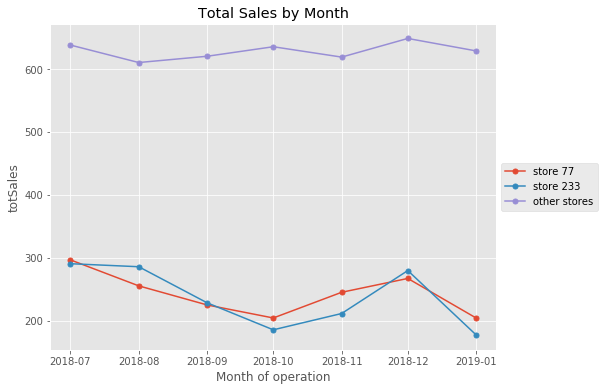

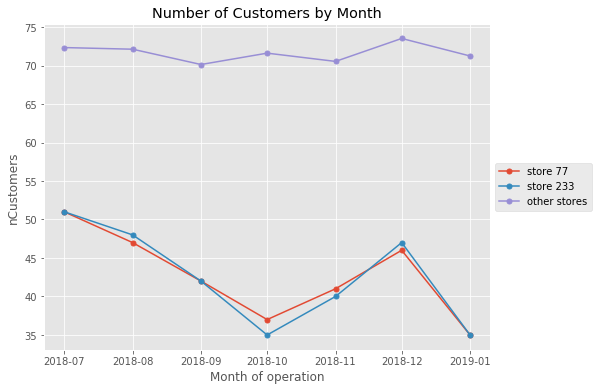

In [10]:
import datetime as dt

def visual_check(trial_store, control_store, metricCol, title):
    fig, ax = plt.subplots(figsize=(8,6))
    other_stores = preTrialMeasures.loc[~preTrialMeasures['STORE_NBR'].isin([trial_store, control_store]), :]
    other_stores = other_stores.groupby('YEARMONTH')[metricCol].mean()
    
    for store in [trial_store, control_store]:
        months = preTrialMeasures.loc[preTrialMeasures['STORE_NBR'] == store, 'YEARMONTH']
        months = months.apply(lambda e:dt.datetime.strptime(str(e), '%Y%m'))
        sales = preTrialMeasures.loc[preTrialMeasures['STORE_NBR'] == store, metricCol]
        ax.plot(months, sales, '-o', label='store '+str(store), markersize=5)
    
    ax.plot(months, other_stores, '-o', label='other stores', markersize=5)
    
    ax.set_xlabel('Month of operation')
    ax.set_ylabel(metricCol)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

visual_check(trial_store_1, control_store_1, 'totSales', 'Total Sales by Month')
visual_check(trial_store_1, control_store_1, 'nCustomers', 'Number of Customers by Month')

### Scaling control store sales

In [11]:
def get_scaled_values(trial_store, control_store, metricCol):
    t_sum = preTrialMeasures.loc[preTrialMeasures['STORE_NBR'] == trial_store, metricCol].sum()
    c_sum = preTrialMeasures.loc[preTrialMeasures['STORE_NBR'] == control_store, metricCol].sum()

    scalingFactor = t_sum / c_sum

    scaledMetricCol = measureOverTime.loc[measureOverTime['STORE_NBR'] == control_store,
                                          [metricCol, 'YEARMONTH']]
    
    scaledMetricCol[metricCol] = scaledMetricCol[metricCol] * scalingFactor
    scaledMetricCol.reset_index(inplace=True, drop=True)
    return scaledMetricCol

scaledControlSales = get_scaled_values(trial_store_1, control_store_1, 'totSales')
scaledControlSales

,totSales,YEARMONTH
0,297.565550,201807
1,292.652187,201808
2,233.998916,201809
3,190.085733,201810
4,216.597421,201811
5,286.408121,201812
6,181.692071,201901
7,249.762622,201902
8,203.802205,201903
9,162.345704,201904


### Calculating percentage difference

In [12]:
def cal_percentageDiff(trial_store_metrics, scaled_control_store_metrics, metricCol):
    percentageDiff = pd.DataFrame(trial_store_metrics['YEARMONTH'])
    percentageDiff['percentageDiff'] = (abs(scaled_control_store_metrics[metricCol] - 
                                            trial_store_metrics[metricCol]) / 
                                        (scaled_control_store_metrics[metricCol]))
    return percentageDiff

trial_store1_sales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store_1, ['totSales', 'YEARMONTH']]
trial_store1_sales.reset_index(inplace=True, drop=True)

percentageDiff = cal_percentageDiff(trial_store1_sales, scaledControlSales, 'totSales')
percentageDiff

,YEARMONTH,percentageDiff
0,201807,0.002573
1,201808,0.126950
2,201809,0.037602
3,201810,0.075830
4,201811,0.132516
5,201812,0.066716
6,201901,0.124980
7,201902,0.059107
8,201903,0.366521
9,201904,0.623080


### Calculating t-values for trial months

In [13]:
from math import sqrt
from scipy import stats

def get_tvalues(x, std, n, alpha):
    tvalue = ((x - 0) / std)
    degreesOfFreedom = n-1
    critical_t = stats.t.ppf(1-(alpha), degreesOfFreedom) #one-tail
    return round(tvalue, 3), round(critical_t, 3)

stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()
n = len(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
alpha = 0.05

trial_months_tvalues = {}
trial_months = [201902,201903,201904]
for trial_month in trial_months:
    x = percentageDiff.loc[percentageDiff['YEARMONTH'] == trial_month, 'percentageDiff']
    x = x.values[0]
    t, t0 = get_tvalues(x, stdDev, n, alpha)
    trial_months_tvalues[trial_month] = (t, t0)

trial_months_tvalues

{201902: (1.184, 1.943), 201903: (7.339, 1.943), 201904: (12.476, 1.943)}

###### We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
###### Note - there are 7 months in the pre-trial period i.e. 2018-07 to 2019-01 and not 8 as mentioned in the solution template.
###### Hence, degrees of freedom should be 7-1 = 6

### Assessing trial period for total sales

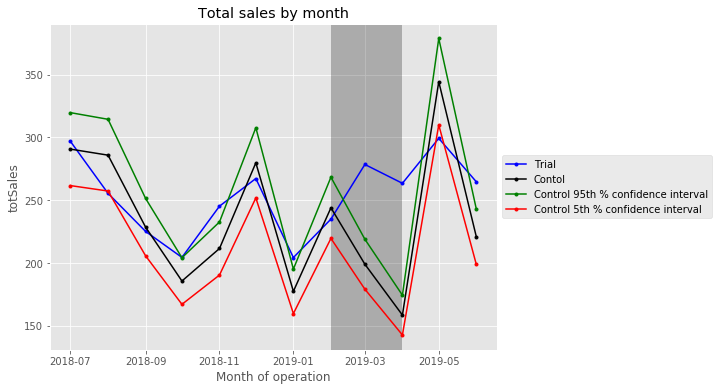

In [14]:
from matplotlib.patches import Rectangle

def visualize_trial_assessment(trial_store, control_store, metricCol, stdDev, title):
    trial_metrics = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store,
                                        ['YEARMONTH', metricCol]]
    control_metrics = measureOverTime.loc[measureOverTime['STORE_NBR'] == control_store,
                                          ['YEARMONTH', metricCol]]
    past_Controls95 = control_metrics[metricCol] * (1 + stdDev * 2)
    past_Controls5 = control_metrics[metricCol] * (1 - stdDev * 2)

    months = trial_metrics['YEARMONTH'].apply(lambda e:dt.datetime.strptime(str(e), '%Y%m'))
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(months, trial_metrics[metricCol], '-o', color='b', label='Trial', markersize=3)
    ax.plot(months, control_metrics[metricCol], '-o', color='k', label='Contol', markersize=3)
    ax.plot(months, past_Controls95, '-o', color='g', label='Control 95th % confidence interval', markersize=3)
    ax.plot(months, past_Controls5, '-o', color='r', label='Control 5th % confidence interval', markersize=3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    start = months.iloc[7]
    end = months.iloc[9]
    width = end - start
    
    rect = Rectangle((start,0), width, plt.ylim()[1], facecolor='k', alpha=0.25)
    ax.add_patch(rect)
    ax.set_xlabel('Month of operation')
    ax.set_ylabel(metricCol)
    ax.set_title(title)
    plt.show()
    
visualize_trial_assessment(trial_store_1, control_store_1, 'totSales', stdDev, 'Total sales by month')

### For number of Customers

In [15]:
scaledControlCustomers = get_scaled_values(trial_store_1, control_store_1, 'nCustomers')
scaledControlCustomers

,nCustomers,YEARMONTH
0,51.171141,201807
1,48.161074,201808
2,42.140940,201809
3,35.117450,201810
4,40.134228,201811
5,47.157718,201812
6,35.117450,201901
7,45.151007,201902
8,40.134228,201903
9,30.100671,201904


In [16]:
trial_store1_custs = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store_1, ['nCustomers', 'YEARMONTH']]
trial_store1_custs.reset_index(inplace=True, drop=True)

percentageDiff = cal_percentageDiff(trial_store1_custs, scaledControlCustomers, 'nCustomers')
percentageDiff

,YEARMONTH,percentageDiff
0,201807,0.003344
1,201808,0.024108
2,201809,0.003344
3,201810,0.053607
4,201811,0.021572
5,201812,0.024550
6,201901,0.003344
7,201902,0.003344
8,201903,0.245819
9,201904,0.561427


### Assessing trial period for number of customers

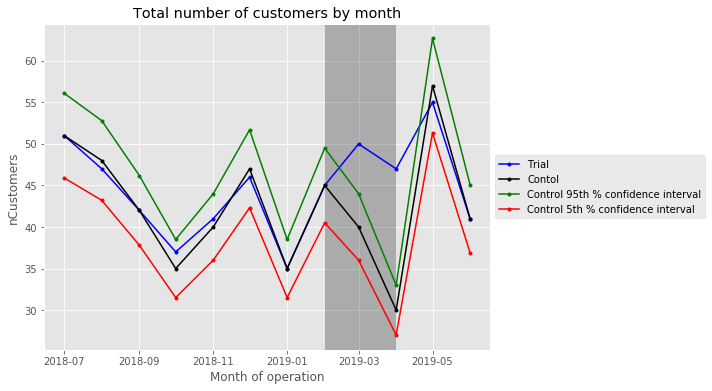

In [17]:
visualize_trial_assessment(trial_store_1, control_store_1, 'nCustomers', stdDev, 'Total number of customers by month')

### For trial store 86

In [18]:
trial_store_2 = 86
score_Control_2 = get_score_Control(trial_store_2)
score_Control_2

,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
0,86,86,1.000000,1.000000,1.000000
1,86,155,0.921777,0.964824,0.943300
2,86,109,0.877439,0.870177,0.873808
3,86,114,0.830855,0.898569,0.864712
4,86,138,0.845335,0.842443,0.843889
...,...,...,...,...,...
255,86,108,-0.224603,-0.146903,-0.185753
256,86,52,-0.243839,-0.231754,-0.237796
257,86,120,-0.317708,-0.192601,-0.255155
258,86,42,-0.322704,-0.267661,-0.295183


In [19]:
control_store_2 = score_Control_2.iloc[1,1]
control_store_2

155

###### Store 155 is selected as the control store for trial store 86

### Performing Visual Checks

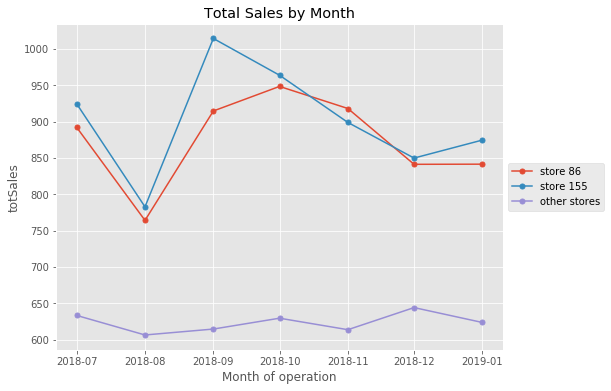

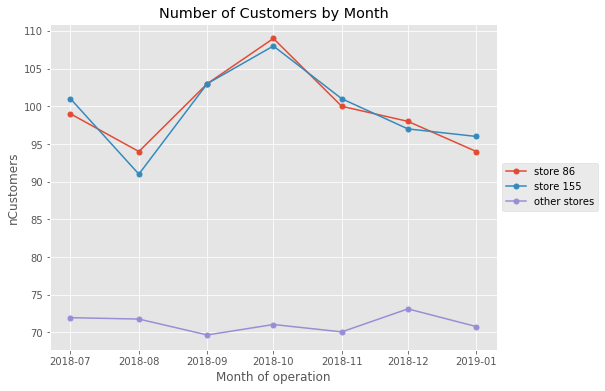

In [20]:
visual_check(trial_store_2, control_store_2, 'totSales', 'Total Sales by Month')
visual_check(trial_store_2, control_store_2, 'nCustomers', 'Number of Customers by Month')

### Scaling control store sales

In [21]:
scaledControlSales = get_scaled_values(trial_store_2, control_store_2, 'totSales')
scaledControlSales

,totSales,YEARMONTH
0,896.922236,201807
1,759.269991,201808
2,984.034086,201809
3,934.948790,201810
4,871.894555,201811
5,824.361363,201812
6,848.418979,201901
7,864.522060,201902
8,780.320405,201903
9,819.317024,201904


### Calculating percentage difference

In [22]:
trial_store2_sales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store_2, ['totSales', 'YEARMONTH']]
trial_store2_sales.reset_index(inplace=True, drop=True)

percentageDiff = cal_percentageDiff(trial_store2_sales, scaledControlSales, 'totSales')
percentageDiff

,YEARMONTH,percentageDiff
0,201807,0.005265
1,201808,0.006296
2,201809,0.070561
3,201810,0.014387
4,201811,0.052880
5,201812,0.020426
6,201901,0.008273
7,201902,0.056306
8,201903,0.315870
9,201904,0.035253


### Assessing trial period for total sales

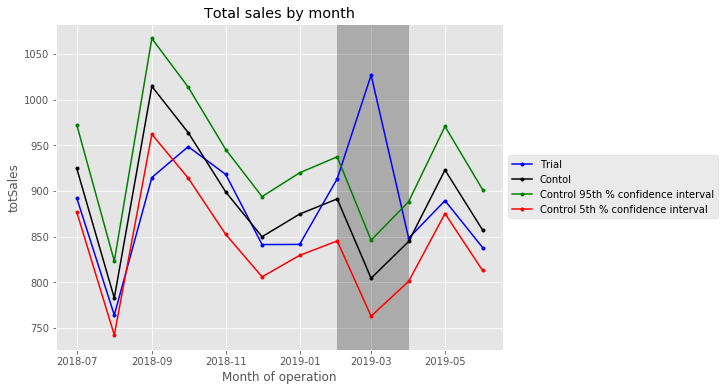

In [23]:
stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()
visualize_trial_assessment(trial_store_2, control_store_2, 'totSales', stdDev, 'Total sales by month')

### For number of customers

In [24]:
scaledControlCustomers = get_scaled_values(trial_store_2, control_store_2, 'nCustomers')
scaledControlCustomers

,nCustomers,YEARMONTH
0,101.0,201807
1,91.0,201808
2,103.0,201809
3,108.0,201810
4,101.0,201811
5,97.0,201812
6,96.0,201901
7,95.0,201902
8,94.0,201903
9,99.0,201904


In [25]:
trial_store2_custs = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store_2, ['nCustomers', 'YEARMONTH']]
trial_store2_custs.reset_index(inplace=True, drop=True)

percentageDiff = cal_percentageDiff(trial_store2_custs, scaledControlCustomers, 'nCustomers')
percentageDiff

,YEARMONTH,percentageDiff
0,201807,0.019802
1,201808,0.032967
2,201809,0.000000
3,201810,0.009259
4,201811,0.009901
5,201812,0.010309
6,201901,0.020833
7,201902,0.126316
8,201903,0.223404
9,201904,0.060606


### Assessing trial period for number of customers

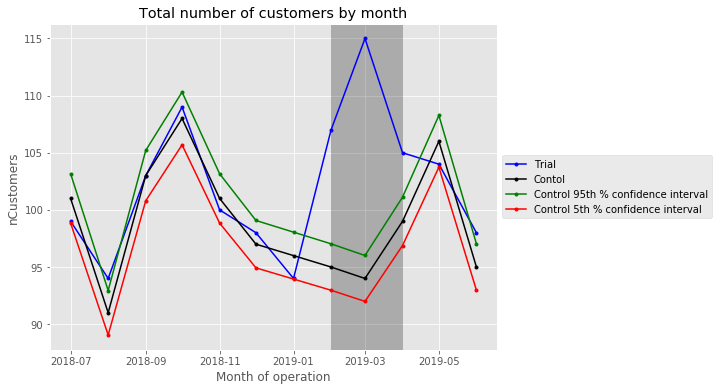

In [26]:
stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()
visualize_trial_assessment(trial_store_2, control_store_2, 'nCustomers', stdDev, 'Total number of customers by month')

### For trial store 88

In [27]:
trial_store_3 = 88
score_Control_3 = get_score_Control(trial_store_3)
score_Control_3

,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
0,88,88,1.000000,1.000000,1.000000
1,88,178,0.722226,0.883908,0.803067
2,88,237,0.633538,0.967572,0.800555
3,88,69,0.587019,0.845327,0.716173
4,88,113,0.598055,0.827772,0.712914
...,...,...,...,...,...
255,88,90,-0.218280,-0.078002,-0.148141
256,88,258,0.078155,-0.385239,-0.153542
257,88,42,-0.226324,-0.106957,-0.166641
258,88,141,-0.223195,-0.110909,-0.167052


In [28]:
control_store_3 = score_Control_3.iloc[2,1]
control_store_3

237

###### Store 237 is selected as the control store for trial store 88
###### Note : store 178 has the second highest ranking according to scores but visual checks suggest store 237 is better which has the third highest ranking

### Performing visual checks

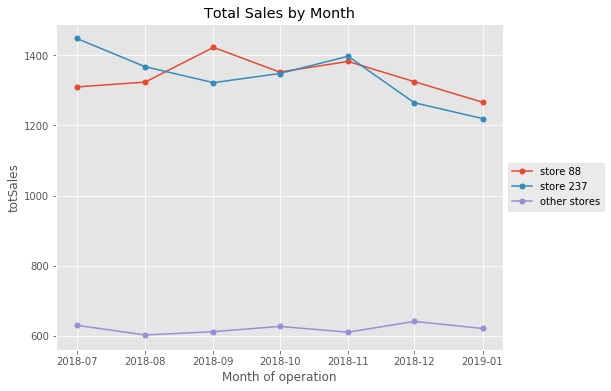

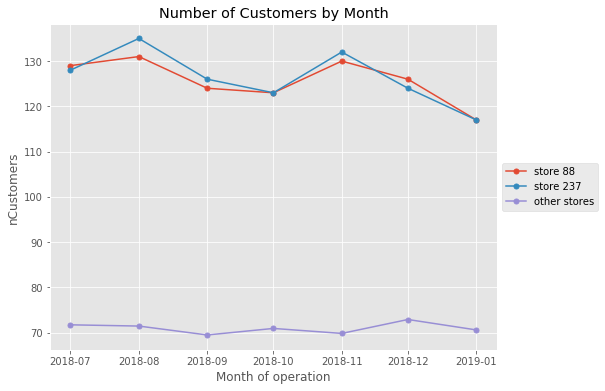

In [29]:
visual_check(trial_store_3, control_store_3, 'totSales', 'Total Sales by Month')
visual_check(trial_store_3, control_store_3, 'nCustomers', 'Number of Customers by Month')

### Scaling control sales

In [30]:
scaledControlSales = get_scaled_values(trial_store_3, control_store_3, 'totSales')
scaledControlSales

,totSales,YEARMONTH
0,1450.657086,201807
1,1369.931485,201808
2,1324.260425,201809
3,1350.401097,201810
4,1399.777923,201811
5,1266.971288,201812
6,1221.600696,201901
7,1406.989143,201902
8,1210.082775,201903
9,1206.477165,201904


In [31]:
trial_store3_sales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store_3, ['totSales', 'YEARMONTH']]
trial_store3_sales.reset_index(inplace=True, drop=True)

percentageDiff = cal_percentageDiff(trial_store3_sales, scaledControlSales, 'totSales')
percentageDiff

,YEARMONTH,percentageDiff
0,201807,0.096961
1,201808,0.033674
2,201809,0.074562
3,201810,0.001480
4,201811,0.012129
5,201812,0.045959
6,201901,0.036673
7,201902,0.026147
8,201903,0.220743
9,201904,0.193060


### Assessing trial period for total sales

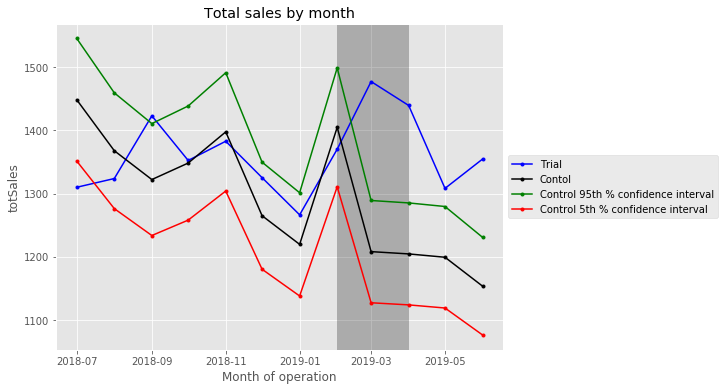

In [32]:
stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()
visualize_trial_assessment(trial_store_3, control_store_3, 'totSales', stdDev, 'Total sales by month')

### For number of customers

In [33]:
scaledControlCustomers = get_scaled_values(trial_store_3, control_store_3, 'nCustomers')
scaledControlCustomers

,nCustomers,YEARMONTH
0,127.276836,201807
1,134.237288,201808
2,125.288136,201809
3,122.305085,201810
4,131.254237,201811
5,123.299435,201812
6,116.338983,201901
7,125.288136,201902
8,118.327684,201903
9,119.322034,201904


In [34]:
trial_store3_custs = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store_3, ['nCustomers', 'YEARMONTH']]
trial_store3_custs.reset_index(inplace=True, drop=True)

percentageDiff = cal_percentageDiff(trial_store3_custs, scaledControlCustomers, 'nCustomers')
percentageDiff

,YEARMONTH,percentageDiff
0,201807,0.013539
1,201808,0.024116
2,201809,0.010281
3,201810,0.005682
4,201811,0.009556
5,201812,0.021902
6,201901,0.005682
7,201902,0.010281
8,201903,0.132448
9,201904,0.072727


### Assessing trial period for number of customers

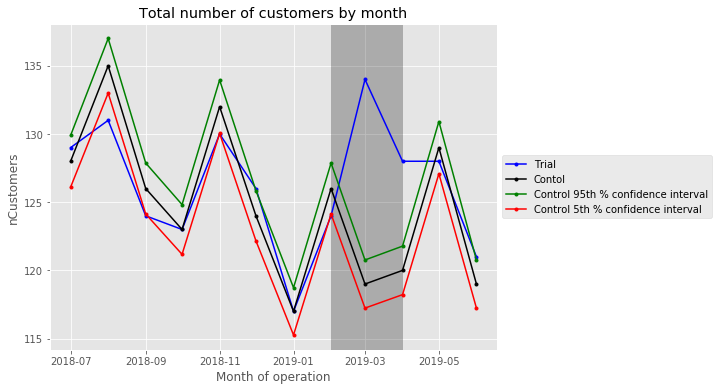

In [35]:
stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()
visualize_trial_assessment(trial_store_3, control_store_3, 'nCustomers', stdDev, 'Total number of customers by month')